In [1]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [3]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)

Text(0, 0.5, 'Price USD ($)')

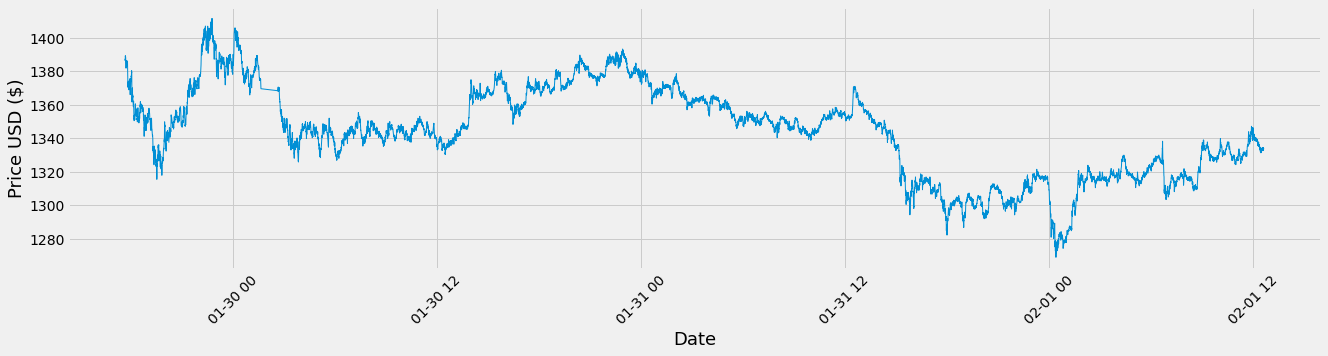

In [4]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
# plt.show()

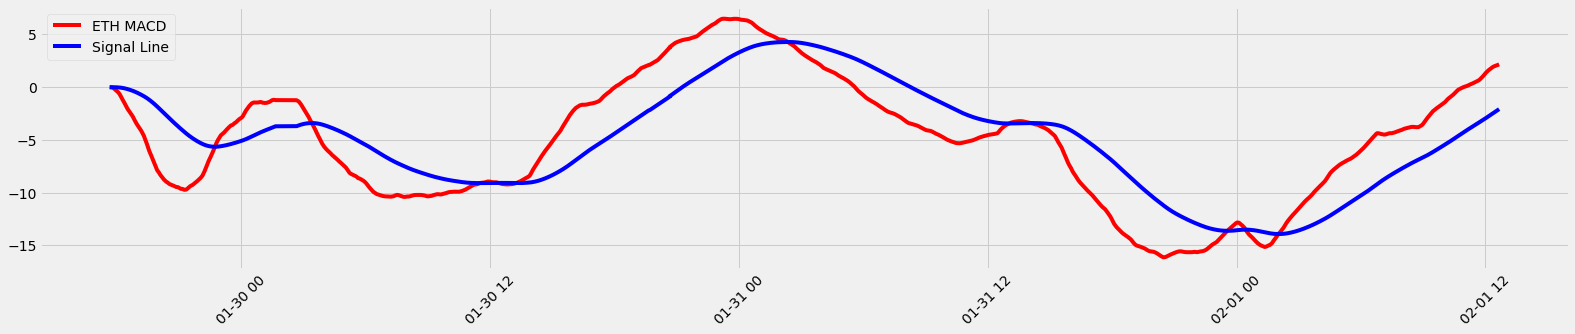

In [5]:
def createMacdAndSignalLines(macd_params, macd_multiplier):
    ShortEMA = df.price.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = df.price.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 175
macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)

plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label='ETH MACD', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
# profit, trans = mac_daddy_tester(MACD, signal, df)
# print((i, profit))
# t.insert((i, profit))

In [7]:
df['MACD'] = macd
df['Signal Line'] = signal

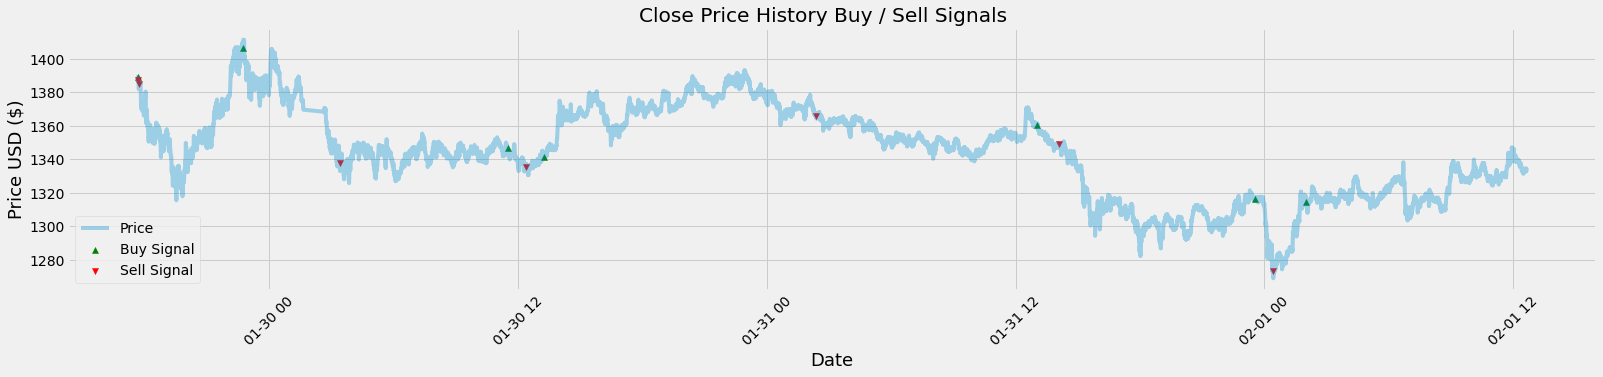

2021-01-29T17:43:00Z Bought at 1389.93  selling at 1379.72 for profit: -12.210000000000036
2021-01-30T03:25:00Z Bought at 1407.424423  selling at 1332.87 for profit: -76.55442300000004
2021-01-30T12:24:15Z Bought at 1350.925  selling at 1331.49 for profit: -21.434999999999945
2021-01-31T02:22:00Z Bought at 1342.155  selling at 1362.805 for profit: 18.65000000000009
2021-01-31T14:04:15Z Bought at 1364.07  selling at 1345.19 for profit: -20.87999999999988
2021-02-01T00:26:00Z Bought at 1312.515  selling at 1276.225 for profit: -38.29000000000019
Profit -144.719423
trans:  6


In [9]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] > signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] < signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("trans: ", len(r[1]))
# print(r[1])

In [10]:
results = []
for period_length in np.arange(5, 700, 5):
    macd_params = (12, 26, 9)
    macd_multiplier = period_length #was 111
    macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)
    r = mac_daddy_tester(macd, signal, df, quiet=True)
    results.append((period_length, r[0], len(r[1])))
    # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))
sorted(results, key = lambda x: -x[1])

[(325, -21.12000000000012, 2),
 (390, -23.064999999999827, 2),
 (410, -23.75999999999999, 2),
 (360, -26.27500000000009, 2),
 (540, -26.820000000000164, 2),
 (440, -27.019999999999982, 2),
 (500, -27.899999999999864, 2),
 (400, -27.964999999999918, 2),
 (405, -28.575000000000045, 2),
 (555, -28.74000000000001, 2),
 (365, -28.875, 2),
 (660, -29.035000000000082, 2),
 (450, -29.12000000000012, 2),
 (435, -31.139999999999873, 2),
 (385, -31.825000000000045, 2),
 (470, -31.910000000000082, 2),
 (650, -31.920000000000073, 2),
 (465, -31.970000000000027, 2),
 (415, -32.62000000000012, 2),
 (490, -32.85500000000002, 2),
 (485, -32.95499999999993, 2),
 (545, -33.0150000000001, 2),
 (425, -33.450000000000045, 2),
 (460, -33.62999999999988, 2),
 (355, -33.840000000000146, 2),
 (550, -33.87000000000012, 2),
 (665, -34.069999999999936, 2),
 (535, -34.075000000000045, 2),
 (560, -34.960000000000036, 2),
 (520, -35.09999999999991, 2),
 (530, -35.54000000000019, 2),
 (370, -35.710000000000036, 2),
 (